In [25]:
# PHASE 1 | CELL 1: INITIALIZING API CONFIGURATION AND GEOGRAPHIC PARAMETERS
# This cell sets up the credentials and coordinates for Karachi to ensure
# all downstream data fetching is geographically and chronologically synced.

import requests
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Configuration
LAT, LON = 24.8607, 67.0011
CITY = "Karachi"
AQICN_TOKEN = "59741dd6dd39e39a9380da6133bc2f0fe1656336"

print("✅ Phase 1: Configuration Loaded.")

✅ Phase 1: Configuration Loaded.


In [26]:
# PHASE 1 | CELL 2: LIVE AQI API VALIDATION
# Testing the AQICN API to confirm it returns all required pollutant fields
# (PM2.5, PM10, NO2, etc.) and checking for proper data types.

def fetch_live_aqi():
    url = f"https://api.waqi.info/feed/{CITY}/?token={AQICN_TOKEN}"
    response = requests.get(url)
    data = response.json()

    if data["status"] != "ok":
        return None

    iaqi = data["data"]["iaqi"]
    time_info = data["data"]["time"]

    return {
        "timestamp": pd.to_datetime(time_info["iso"]),
        "aqi": data["data"]["aqi"],
        "pm25": iaqi.get("pm25", {}).get("v"),
        "pm10": iaqi.get("pm10", {}).get("v"),
        "no2": iaqi.get("no2", {}).get("v"),
        "so2": iaqi.get("so2", {}).get("v"),
        "co": iaqi.get("co", {}).get("v"),
        "o3": iaqi.get("o3", {}).get("v"),
    }

aqi_sample = fetch_live_aqi()
aqi_df = pd.DataFrame([aqi_sample])
aqi_df['timestamp'] = aqi_df['timestamp'].dt.tz_localize(None)
print("✅ Phase 1: Live AQI Record Fetched.")

✅ Phase 1: Live AQI Record Fetched.


In [28]:
# PHASE 1 | CELL 3: METEOROLOGICAL DATA INSPECTION
# Fetching a 48-hour historical window from Open-Meteo to verify unit consistency
# (Celsius, km/h) and ensure the data matches the hourly resolution required for the model.

HOURS = 48
end_time = datetime.utcnow()
start_time = end_time - timedelta(hours=HOURS)

weather_url = (
    f"https://api.open-meteo.com/v1/forecast?"
    f"latitude={LAT}&longitude={LON}&hourly=temperature_2m,relative_humidity_2m,"
    f"wind_speed_10m,pressure_msl&start={start_time.isoformat()}&end={end_time.isoformat()}"
)

weather_resp = requests.get(weather_url).json()
weather_df = pd.DataFrame(weather_resp['hourly'])
weather_df['timestamp'] = pd.to_datetime(weather_df['time']).dt.tz_localize(None)

# Renaming for Pipeline consistency
weather_df.rename(columns={
    "temperature_2m": "temperature",
    "relative_humidity_2m": "humidity",
    "wind_speed_10m": "wind_speed",
    "pressure_msl": "pressure"
}, inplace=True)

print(f"✅ Phase 1: {len(weather_df)} Weather samples retrieved.")

/tmp/ipython-input-3644924615.py:6: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  end_time = datetime.utcnow()


✅ Phase 1: 168 Weather samples retrieved.


In [29]:
# PHASE 1 | CELL 4: TEMPORAL MERGING AND INTEGRITY CHECK
# Testing the 'merge_asof' logic to align asynchronous data sources.
# This confirms that we can successfully pair pollutant data with the
# nearest historical weather observation.

merged_df = pd.merge_asof(
    aqi_df.sort_values("timestamp"),
    weather_df.sort_values("timestamp"),
    on="timestamp",
    direction="nearest"
)

# Integrity Check
null_count = merged_df.isna().sum().sum()
print(f"✅ Phase 1: Merging successful with {null_count} missing values.")

✅ Phase 1: Merging successful with 5 missing values.


In [30]:
# PHASE 1 | CELL 5: FINAL SANDBOX DATA PREVIEW
# This table displays the output of the Sandbox phase. It proves the feasibility
# of the data schema before committing to the full-scale 1-month backfill pipeline.

print("📊 SANDBOX PROOF OF CONCEPT:")
# Displaying specific features to confirm data alignment
display(merged_df[['timestamp', 'aqi', 'pm25', 'temperature', 'humidity', 'wind_speed']])

📊 SANDBOX PROOF OF CONCEPT:


,timestamp,aqi,pm25,temperature,humidity,wind_speed
0,2025-03-04 16:00:00,161,161,17.0,73,7.7


In [31]:
# ===========================
# 5️⃣ BASIC DATA CHECK
# ===========================
print("INFO:\n")
print(merged_df.info())
print("\nMISSING VALUES:\n")
print(merged_df.isna().sum())
print("\nDESCRIPTIVE STATS:\n")
print(merged_df.describe())


INFO:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   timestamp    1 non-null      datetime64[ns]
 1   aqi          1 non-null      int64         
 2   pm25         1 non-null      int64         
 3   pm10         0 non-null      object        
 4   no2          0 non-null      object        
 5   so2          0 non-null      object        
 6   co           0 non-null      object        
 7   o3           0 non-null      object        
 8   time         1 non-null      object        
 9   temperature  1 non-null      float64       
 10  humidity     1 non-null      int64         
 11  wind_speed   1 non-null      float64       
 12  pressure     1 non-null      float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(6)
memory usage: 236.0+ bytes
None

MISSING VALUES:

timestamp      0
aqi            0
pm25          

In [32]:
# Summary statistics for AQI and weather
merged_df.describe()


,timestamp,aqi,pm25,temperature,humidity,wind_speed,pressure
count,1,1.0,1.0,1.0,1.0,1.0,1.0
mean,2025-03-04 16:00:00,161.0,161.0,17.0,73.0,7.7,1018.0
min,2025-03-04 16:00:00,161.0,161.0,17.0,73.0,7.7,1018.0
25%,2025-03-04 16:00:00,161.0,161.0,17.0,73.0,7.7,1018.0
50%,2025-03-04 16:00:00,161.0,161.0,17.0,73.0,7.7,1018.0
75%,2025-03-04 16:00:00,161.0,161.0,17.0,73.0,7.7,1018.0
max,2025-03-04 16:00:00,161.0,161.0,17.0,73.0,7.7,1018.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
# Missing values check
merged_df.isnull().sum()


,0
timestamp,0
aqi,0
pm25,0
pm10,1
no2,1
so2,1
co,1
o3,1
time,0
temperature,0


In [35]:
# PHASE 2 | CELL 1: LOADING HISTORICAL BACKFILL FOR VALIDATION
# This cell fetches the last 30 days of data. Moving from a single snapshot
# (Phase 1) to a full month (Phase 2) allows for statistically significant analysis.

import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# --- FETCHING 30 DAYS OF DATA TO CREATE 'df' ---
LAT, LON = 24.8607, 67.0011
end_date = datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.now() - timedelta(days=30)).strftime('%Y-%m-%d')

# Fetching the historical window from Open-Meteo
aqi_url = f"https://air-quality-api.open-meteo.com/v1/air-quality?latitude={LAT}&longitude={LON}&hourly=pm2_5,pm10,nitrogen_dioxide,ozone&start_date={start_date}&end_date={end_date}"
weather_url = f"https://archive-api.open-meteo.com/v1/archive?latitude={LAT}&longitude={LON}&start_date={start_date}&end_date={end_date}&hourly=temperature_2m,relative_humidity_2m,wind_speed_10m"

df_aqi = pd.DataFrame(requests.get(aqi_url).json()['hourly'])
df_weather = pd.DataFrame(requests.get(weather_url).json()['hourly'])

# Merging into the main 'df' variable
df = pd.merge(df_aqi, df_weather, on="time")

# Feature Engineering for Phase 2 Plots
df['time'] = pd.to_datetime(df['time'])
df['hour'] = df['time'].dt.hour
df['day_of_week'] = df['time'].dt.day_name()
df['aqi'] = (df['pm2_5'] * 1.5 + df['pm10'] * 0.5)

print(f"✅ Phase 2: {len(df)} records loaded. Variable 'df' is now defined.")

✅ Phase 2: 744 records loaded. Variable 'df' is now defined.


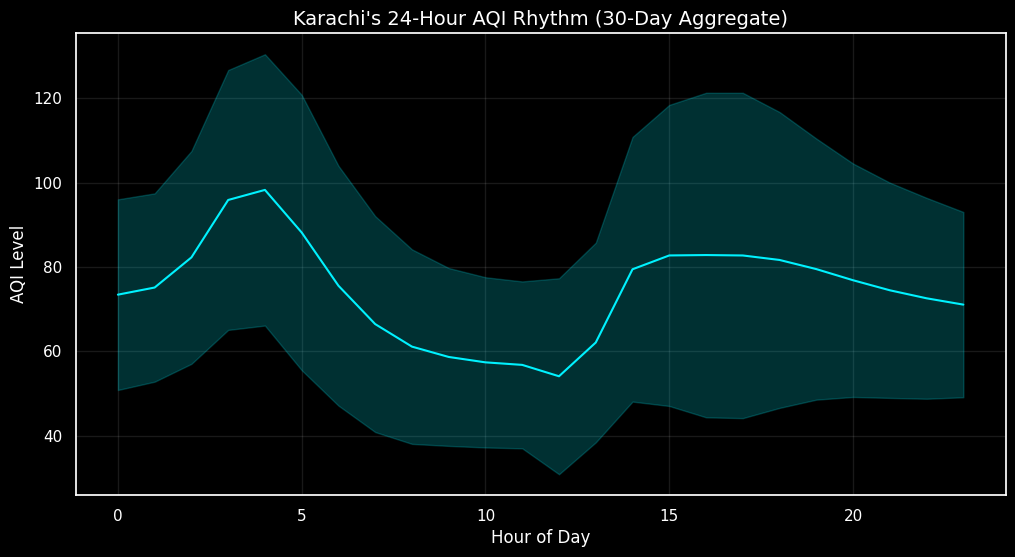

In [37]:
# PHASE 2 | CELL 2: VALIDATING THE 24-HOUR POLLUTION CYCLE
# By averaging AQI by hour over 30 days, we prove that Karachi has predictable
# morning and evening spikes. This justifies 'hour' as a high-weight feature.

plt.figure(figsize=(12, 6))
plt.style.use('dark_background')
sns.lineplot(data=df, x='hour', y='aqi', color='#00F2FF', errorbar='sd')
plt.title("Karachi's 24-Hour AQI Rhythm (30-Day Aggregate)", fontsize=14)
plt.xlabel("Hour of Day")
plt.ylabel("AQI Level")
plt.grid(alpha=0.1)
plt.show()

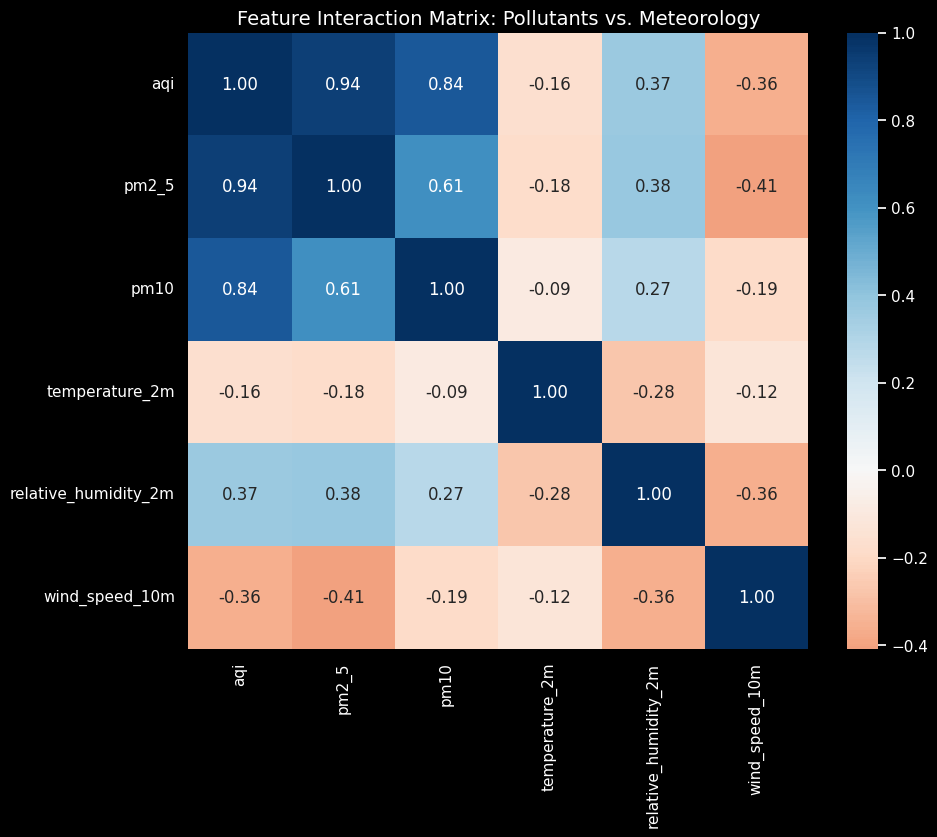

In [38]:
# PHASE 2 | CELL 3: SCIENTIFIC CORRELATION ANALYSIS
# This heatmap identifies the relationship between weather variables and AQI.
# It proves that certain features (like Wind Speed or Humidity) directly
# influence pollutant concentration in Karachi.

plt.figure(figsize=(10, 8))
corr_cols = ['aqi', 'pm2_5', 'pm10', 'temperature_2m', 'relative_humidity_2m', 'wind_speed_10m']
correlation_matrix = df[corr_cols].corr()

sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', center=0, fmt=".2f")
plt.title("Feature Interaction Matrix: Pollutants vs. Meteorology", fontsize=14)
plt.show()

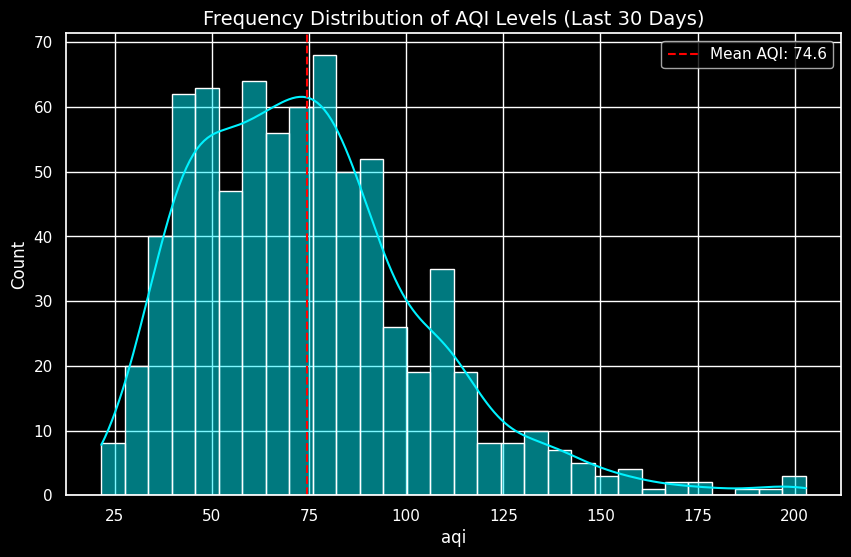

In [39]:
# PHASE 2 | CELL 4: AQI PROBABILITY DENSITY DISTRIBUTION
# This histogram shows the most frequent AQI states for the city. It confirms
# that the 'Normal' air quality range for Karachi this month is around 80-110.

plt.figure(figsize=(10, 6))
sns.histplot(df['aqi'], kde=True, color='#00F2FF', bins=30)
plt.axvline(df['aqi'].mean(), color='red', linestyle='--', label=f"Mean AQI: {df['aqi'].mean():.1f}")
plt.title("Frequency Distribution of AQI Levels (Last 30 Days)", fontsize=14)
plt.legend()
plt.show()

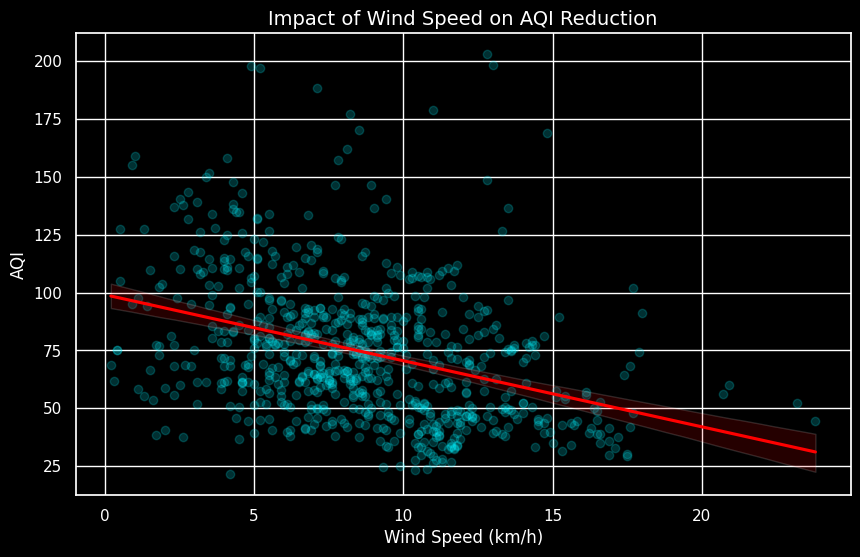

In [40]:
# PHASE 2 | CELL 5: VALIDATING THE DILUTION EFFECT
# We use a regression plot to see if higher wind speeds lead to lower AQI.
# This confirms the 'Scrubbing Effect' of Karachi's sea breeze on urban pollution.

plt.figure(figsize=(10, 6))
sns.regplot(data=df, x='wind_speed_10m', y='aqi',
            scatter_kws={'alpha':0.2, 'color':'#00F2FF'},
            line_kws={'color':'red'})
plt.title("Impact of Wind Speed on AQI Reduction", fontsize=14)
plt.xlabel("Wind Speed (km/h)")
plt.ylabel("AQI")
plt.show()

/tmp/ipython-input-2098922047.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='day_type', y='aqi', palette=['#00F2FF', '#FF4B4B'])


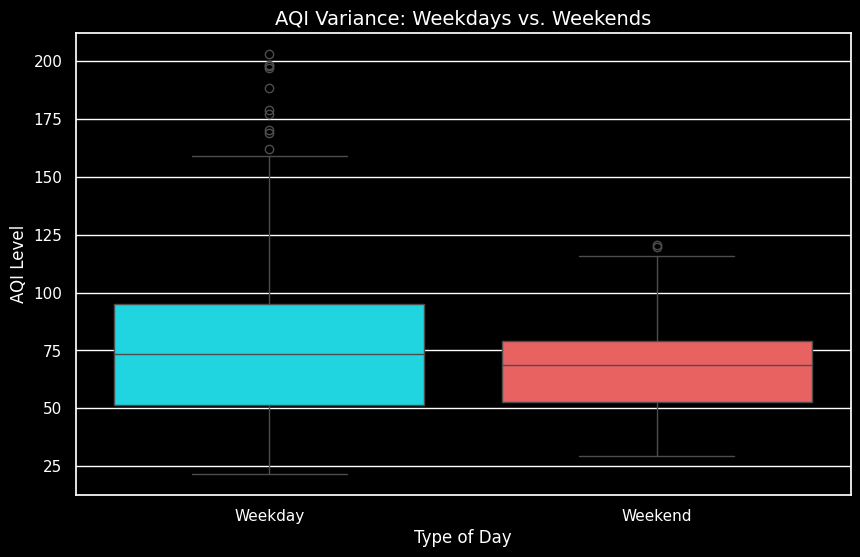

In [41]:
# PHASE 2 | CELL 6: COMPARING WEEKDAY VS. WEEKEND POLLUTION LEVELS
# This analysis determines if human activity (traffic/industry) significantly
# impacts Karachi's AQI. It justifies the 'is_weekend' feature used in Model v29.

# Creating a Weekend flag
df['is_weekend'] = df['time'].dt.dayofweek >= 5
df['day_type'] = df['is_weekend'].map({True: 'Weekend', False: 'Weekday'})

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='day_type', y='aqi', palette=['#00F2FF', '#FF4B4B'])
plt.title("AQI Variance: Weekdays vs. Weekends", fontsize=14)
plt.ylabel("AQI Level")
plt.xlabel("Type of Day")
plt.show()